# League Table

In [13]:
import pandas as pd
import numpy as np

In [14]:
fixtures = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

results = fixtures[fixtures['finished'] == True][['team_a', 'team_a_score', 'team_h', 'team_h_score', 'event']]

league_table = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/teams.csv')[['id', 'name', 'short_name']]
league_table['Points'] = 0

In [15]:
def score_to_points_at_home(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

def score_to_points_at_away(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

In [16]:
def get_gw_league_table(league_table, gw):

    def aggregate_points(team):
        return home_results[home_results['team_h'] == team]['Points'].sum() +\
                away_results[away_results['team_a'] == team]['Points'].sum()

    home_results = results.copy()
    home_results['Points'] = home_results.apply(lambda row: score_to_points_at_home(row), axis=1)
    home_results = (home_results.loc[:, ['team_a', 'team_h', 'Points', 'event']])

    away_results = results.copy()
    away_results['Points'] = away_results.apply(lambda row: score_to_points_at_away(row), axis=1)
    away_results = (away_results.loc[:, ['team_a', 'team_h', 'Points', 'event']])

    if gw > 0:
        home_results = home_results[home_results['event'] <= gw]
        away_results = away_results[away_results['event'] <= gw]

    lt = (league_table.id.map(aggregate_points))
    league_table['Points'] = lt
    return league_table.sort_values(by=['Points'], ascending=False)

In [17]:
season_table = pd.DataFrame()
current_gw = max(results['event'])

for i in range(0, current_gw):
	lt = get_gw_league_table(league_table, i)
	season_table[f'{i}'] = lt.loc[:, 'short_name'].values

In [18]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'ARS': '#EF0107',
    'AVL': '#95bfe5',
    'BHA': '#0057B8',
    'BRE': '#DA291C',
    'BUR': '#6C1D45',
    'CHE': '#034694',
    'CRY': '#1B458F',
    'EVE': '#003399',
    'LEI': '#003090',
    'LEE': '#FFCD00',
    'LIV': '#c8102E',
    'MCI': '#6CABDD',
    'MUN': '#DA291C',
    'NOR': '#FFF200',
    'NEW': '#241F20',
    'SOU': '#d71920',
    'TOT': '#132257',
    'WAT': '#FBEE23',
    'WHU': '#7A263A',
    'WOL': '#FDB913'
}

In [19]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'ARS': '../data/logos/ARS.png',
    'AVL': '../data/logos/AVL.png',
    'BHA': '../data/logos/BHA.png',
    'BRE': '../data/logos/BRE.png',
    'BUR': '../data/logos/BUR.png',
    'CHE': '../data/logos/CHE.png',
    'CRY': '../data/logos/CRY.png',
    'EVE': '../data/logos/EVE.png',
    'LEI': '../data/logos/LEI.png',
    'LEE': '../data/logos/LEE.png',
    'LIV': '../data/logos/LIV.png',
    'MCI': '../data/logos/MCI.png',
    'MUN': '../data/logos/MUN.png',
    'NOR': '../data/logos/NOR.png',
    'NEW': '../data/logos/NEW.png',
    'SOU': '../data/logos/SOU.png',
    'TOT': '../data/logos/TOT.png',
    'WAT': '../data/logos/WAT.png',
    'WHU': '../data/logos/WHU.png',
    'WOL': '../data/logos/WOL.png',
}

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

In [21]:
from glob import glob
import numpy as np

import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import rc

In [22]:
Path = mpath.Path

def bezier_path(p1, p2, color):
    x1, y1 = p1
    x2, y2 = p2

    if y2 != y1:
        path_data = [
            (Path.MOVETO, (x1, y1)),
            (Path.CURVE3, (x1+(x2-x1)/2, y1)),
            (Path.CURVE3, (x1+(x2-x1)/2, y1+(y2-y1)/2)),
            (Path.CURVE3, (x1+(x2-x1)/2, y2)),
            (Path.CURVE3, (x2, y2)),
            ]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, ec=color, fc='none', zorder=2)

    else:
        path_data = [
            (Path.MOVETO, (x1, y1)),
            (Path.LINETO, (x2, y2)),
            ]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, ec=color, fc='none', zorder=2)

    return patch

In [23]:
def imscatter(x, y, image, ax=None, zoom=1):
    """stackoverflow.com/questions/35651932/plotting-img-with-matplotlib/35651933"""
    if ax is None:
        ax = plt.gca()

    try:
        image = plt.imread(image)
    except TypeError:
        pass

    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

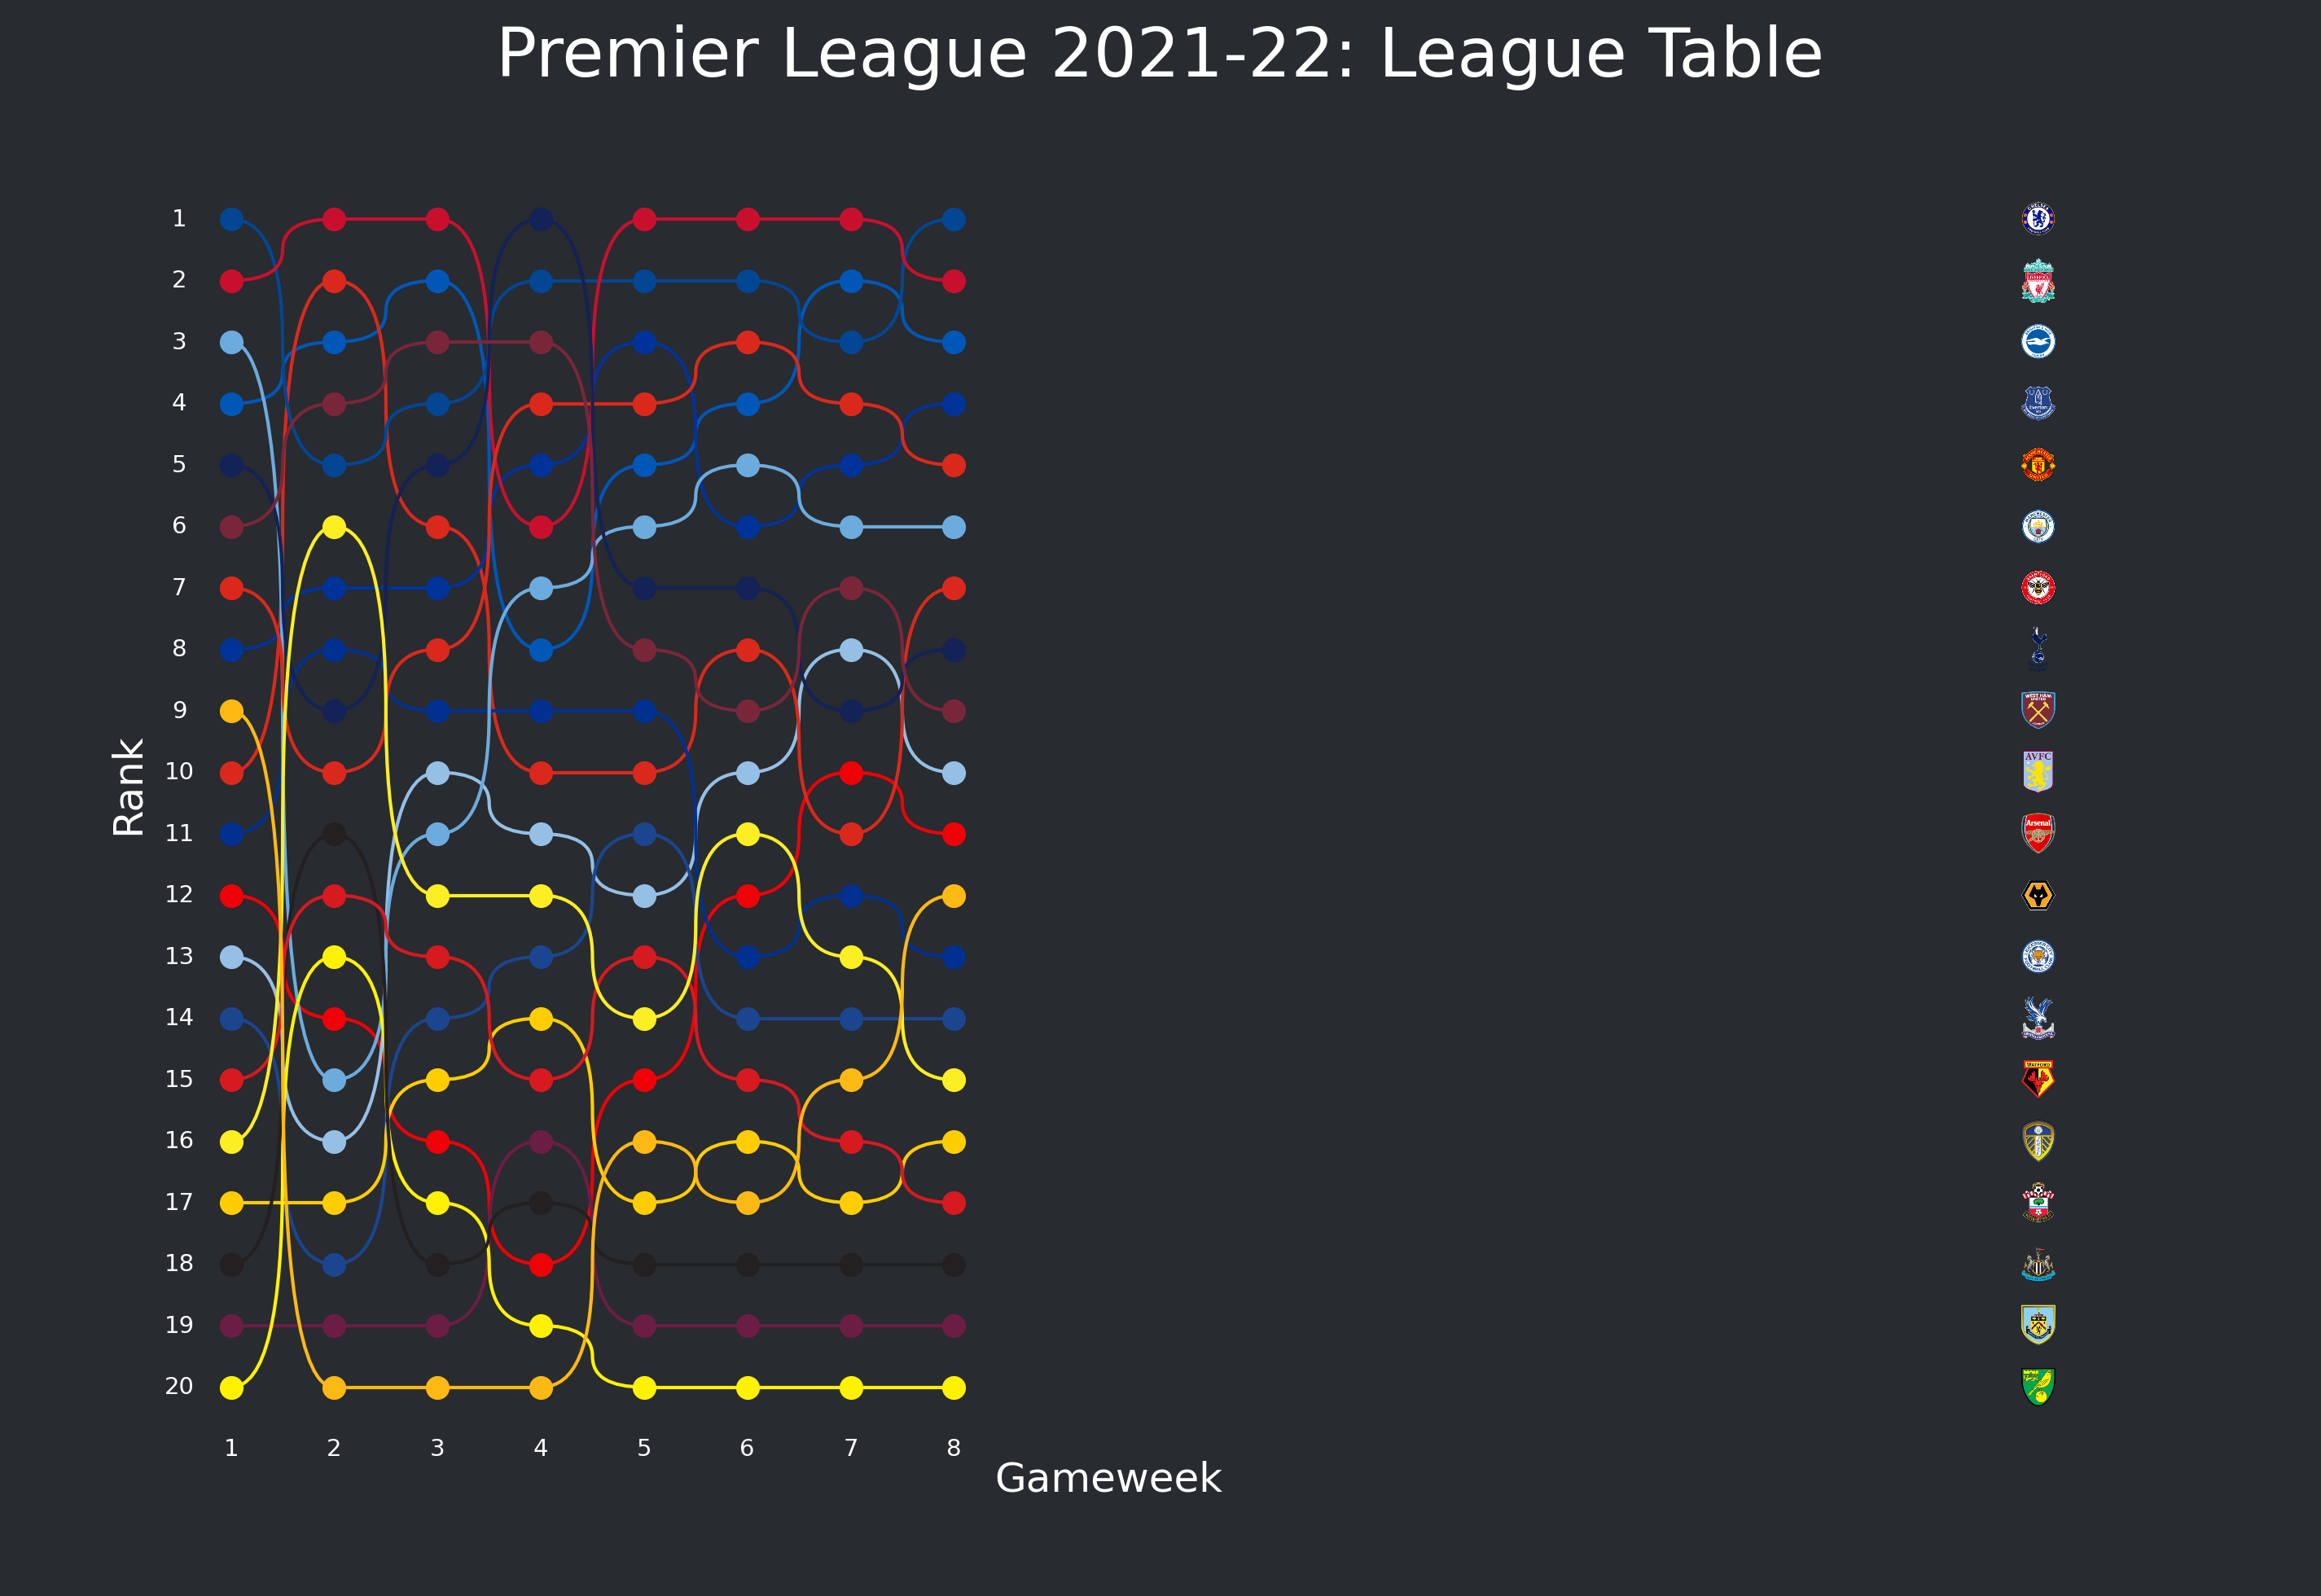

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for team_name, color, img_path in zip(colors.keys(), colors.values(), logos.values()):
    indices = season_table[season_table == team_name].stack().index.tolist()
    coords = [(int(idx[1]), idx[0]) for idx in indices]
    coords = sorted(coords, key=lambda x: x[0])

    # Plot the dot with the team's color
    for idx in indices:
        ax.scatter(int(idx[1]), idx[0], fc=color, zorder=1)

    # Plot the lines
    for p1, p2 in zip(coords[:-1], coords[1:]):
        patch = bezier_path(p1, p2, color)
        ax.add_patch(patch)

    # Plot the team logo
    imscatter(x=17.5, y=coords[-1][-1], image = img_path, ax=ax, zoom=0.1)

ax.set_axis_off()
ax.set(xlim=(-2,20), ylim=(-2,22))
ax.title.set(text='Premier League 2021-22: League Table', fontsize=20)

ax.text(8.5, 20.5, 'Gameweek', fontsize=12, va='center', ha='center')
ax.text(-1, 10, 'Rank', rotation=90, fontsize=12, va='bottom', ha='center')

[ax.text(i, 20, i+1, ha='center', va='center', size=7) for i in range(0, current_gw)]
[ax.text(-0.5, i, i+1, ha='center', va='center', size=7) for i in range(20)]

ax.invert_yaxis()

# XTable

We will use Expected Goals in this part (which is the xG value accumented over the game).

In [25]:
league_table['xPoints'] = 0

In [26]:
def xg_vs_xga(row):
    if np.round(row['npxG'], 2) ==  np.round(row['npxGA'], 2):
        return 1
    elif row['npxG'] > row['npxGA']:
        return 3
    else:
        return 0

In [27]:
league_table.loc[:, 'xPoints'] = [
    (pd.read_csv('../data/understat/2021-22/Arsenal.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Aston_Villa.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Brentford.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Brighton.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Burnley.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Chelsea.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Crystal_Palace.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Everton.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Leeds.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Leicester.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Liverpool.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Manchester_City.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Manchester_United.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Newcastle_United.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Norwich.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Southampton.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Tottenham.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Watford.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/West_Ham.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
    (pd.read_csv('../data/understat/2021-22/Wolverhampton_Wanderers.csv')
     .apply(lambda row: xg_vs_xga(row), axis=1).sum())
]

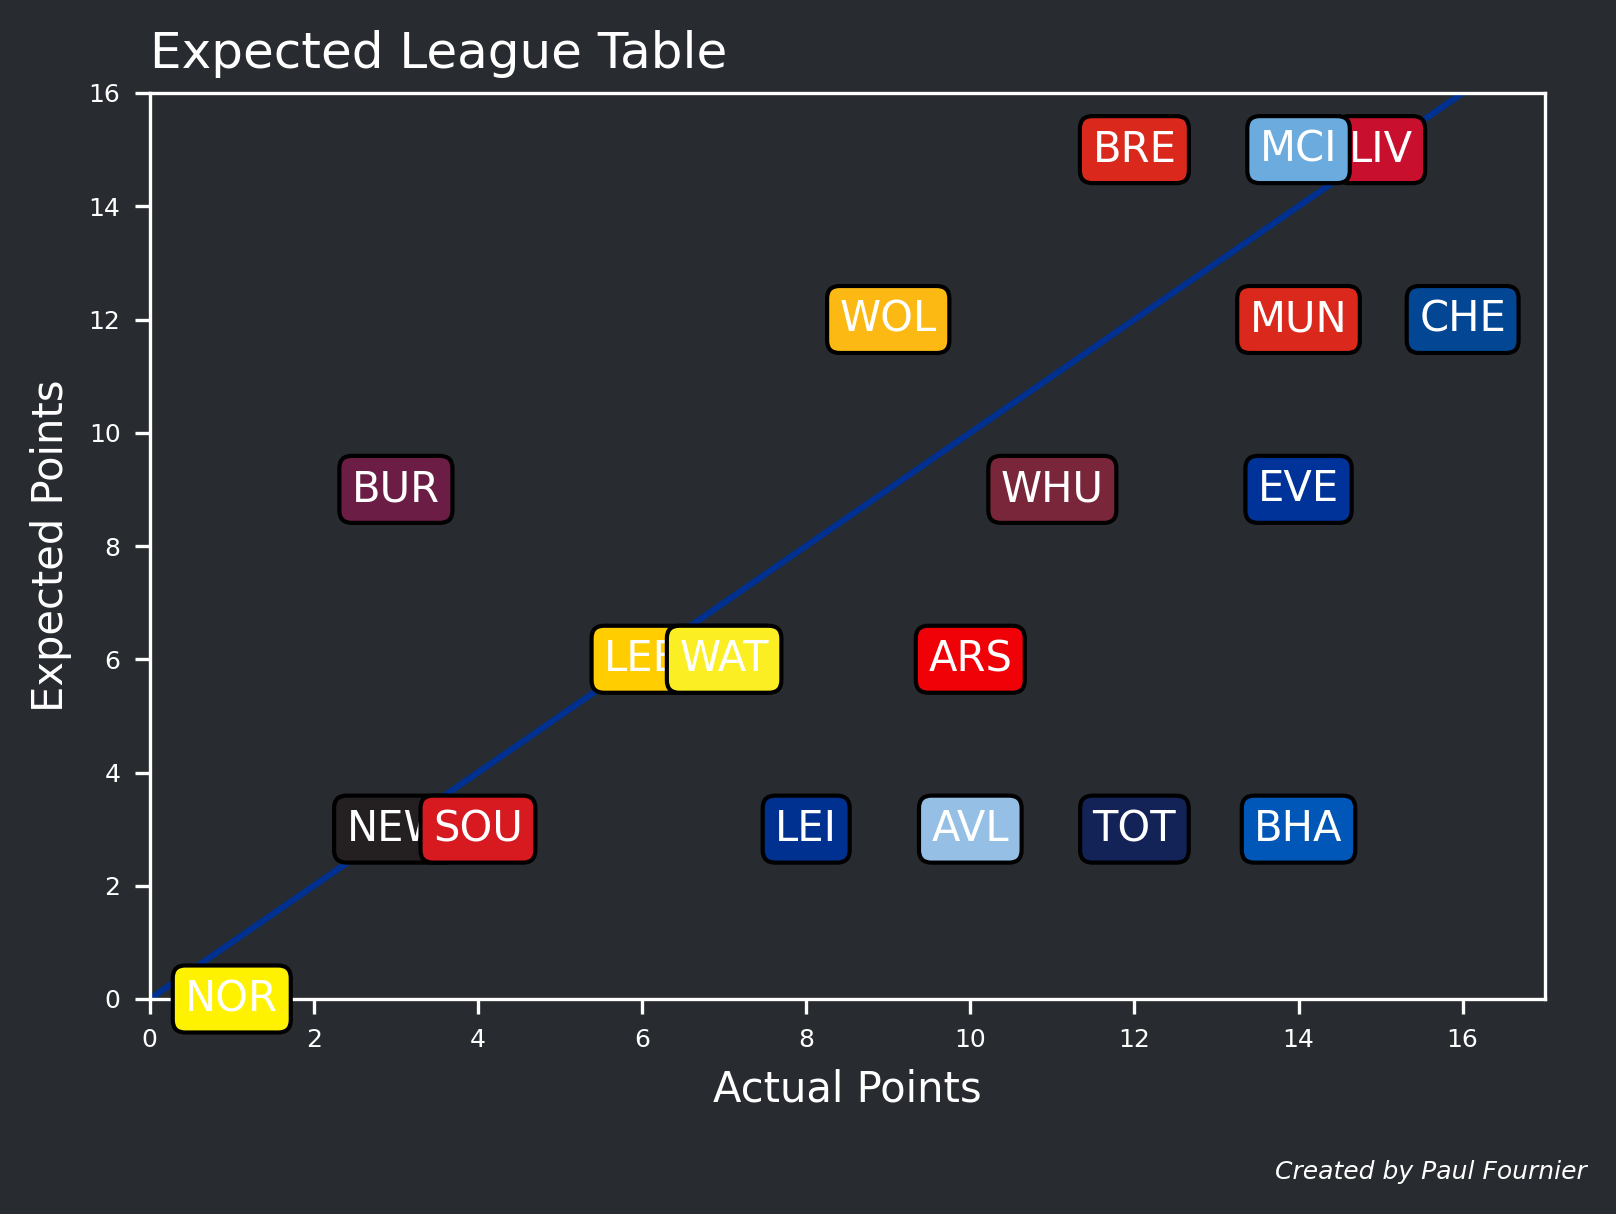

In [28]:
fig, ax = plt.subplots()
fig.set_facecolor(background)
ax.patch.set_alpha(0)

max_1 = league_table["xPoints"].max()
max_2 = league_table["Points"].max()
ax.set(xlim=(0, max_2+1), ylim=(0, max_1+1))

ax.set_xlabel('Actual Points')
ax.set_ylabel('Expected Points')
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

plt.title(f'Expected League Table', loc='left')

ref_line = [0.0, max(max_1, max_2)+1]
ax.plot(ref_line, ref_line, color='#003090')

for idx, row in league_table.iterrows():
    ax.annotate(row.values[2],
                xy=(row["Points"], row["xPoints"]),
                xycoords='data',
                bbox=dict(boxstyle='round', fc=(colors[row.values[2]])),
                ha='center',
                va='center',
                color='white')

fig.text(
    0.75, -0.025, "Created by Paul Fournier",
    fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [29]:
def get_gw_xp_league_table(league_table, gw):

    league_table['xPoints'] = 0
    league_table.loc[:, 'xPoints'] = [
        (pd.read_csv('../data/understat/2021-22/Arsenal.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Aston_Villa.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Brentford.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Brighton.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Burnley.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Chelsea.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Crystal_Palace.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Everton.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Leeds.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Leicester.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Liverpool.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Manchester_City.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Manchester_United.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Newcastle_United.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Norwich.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Southampton.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Tottenham.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Watford.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/West_Ham.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum()),
        (pd.read_csv('../data/understat/2021-22/Wolverhampton_Wanderers.csv').loc[:gw]
        .apply(lambda row: xg_vs_xga(row), axis=1).sum())
    ]

    return league_table.sort_values(by=['xPoints'], ascending=False)

In [30]:
xpts_season_table = pd.DataFrame()

for i in range(0, current_gw):
	lt = get_gw_xp_league_table(league_table, i)
	xpts_season_table[f'{i}'] = lt.loc[:, 'short_name'].values

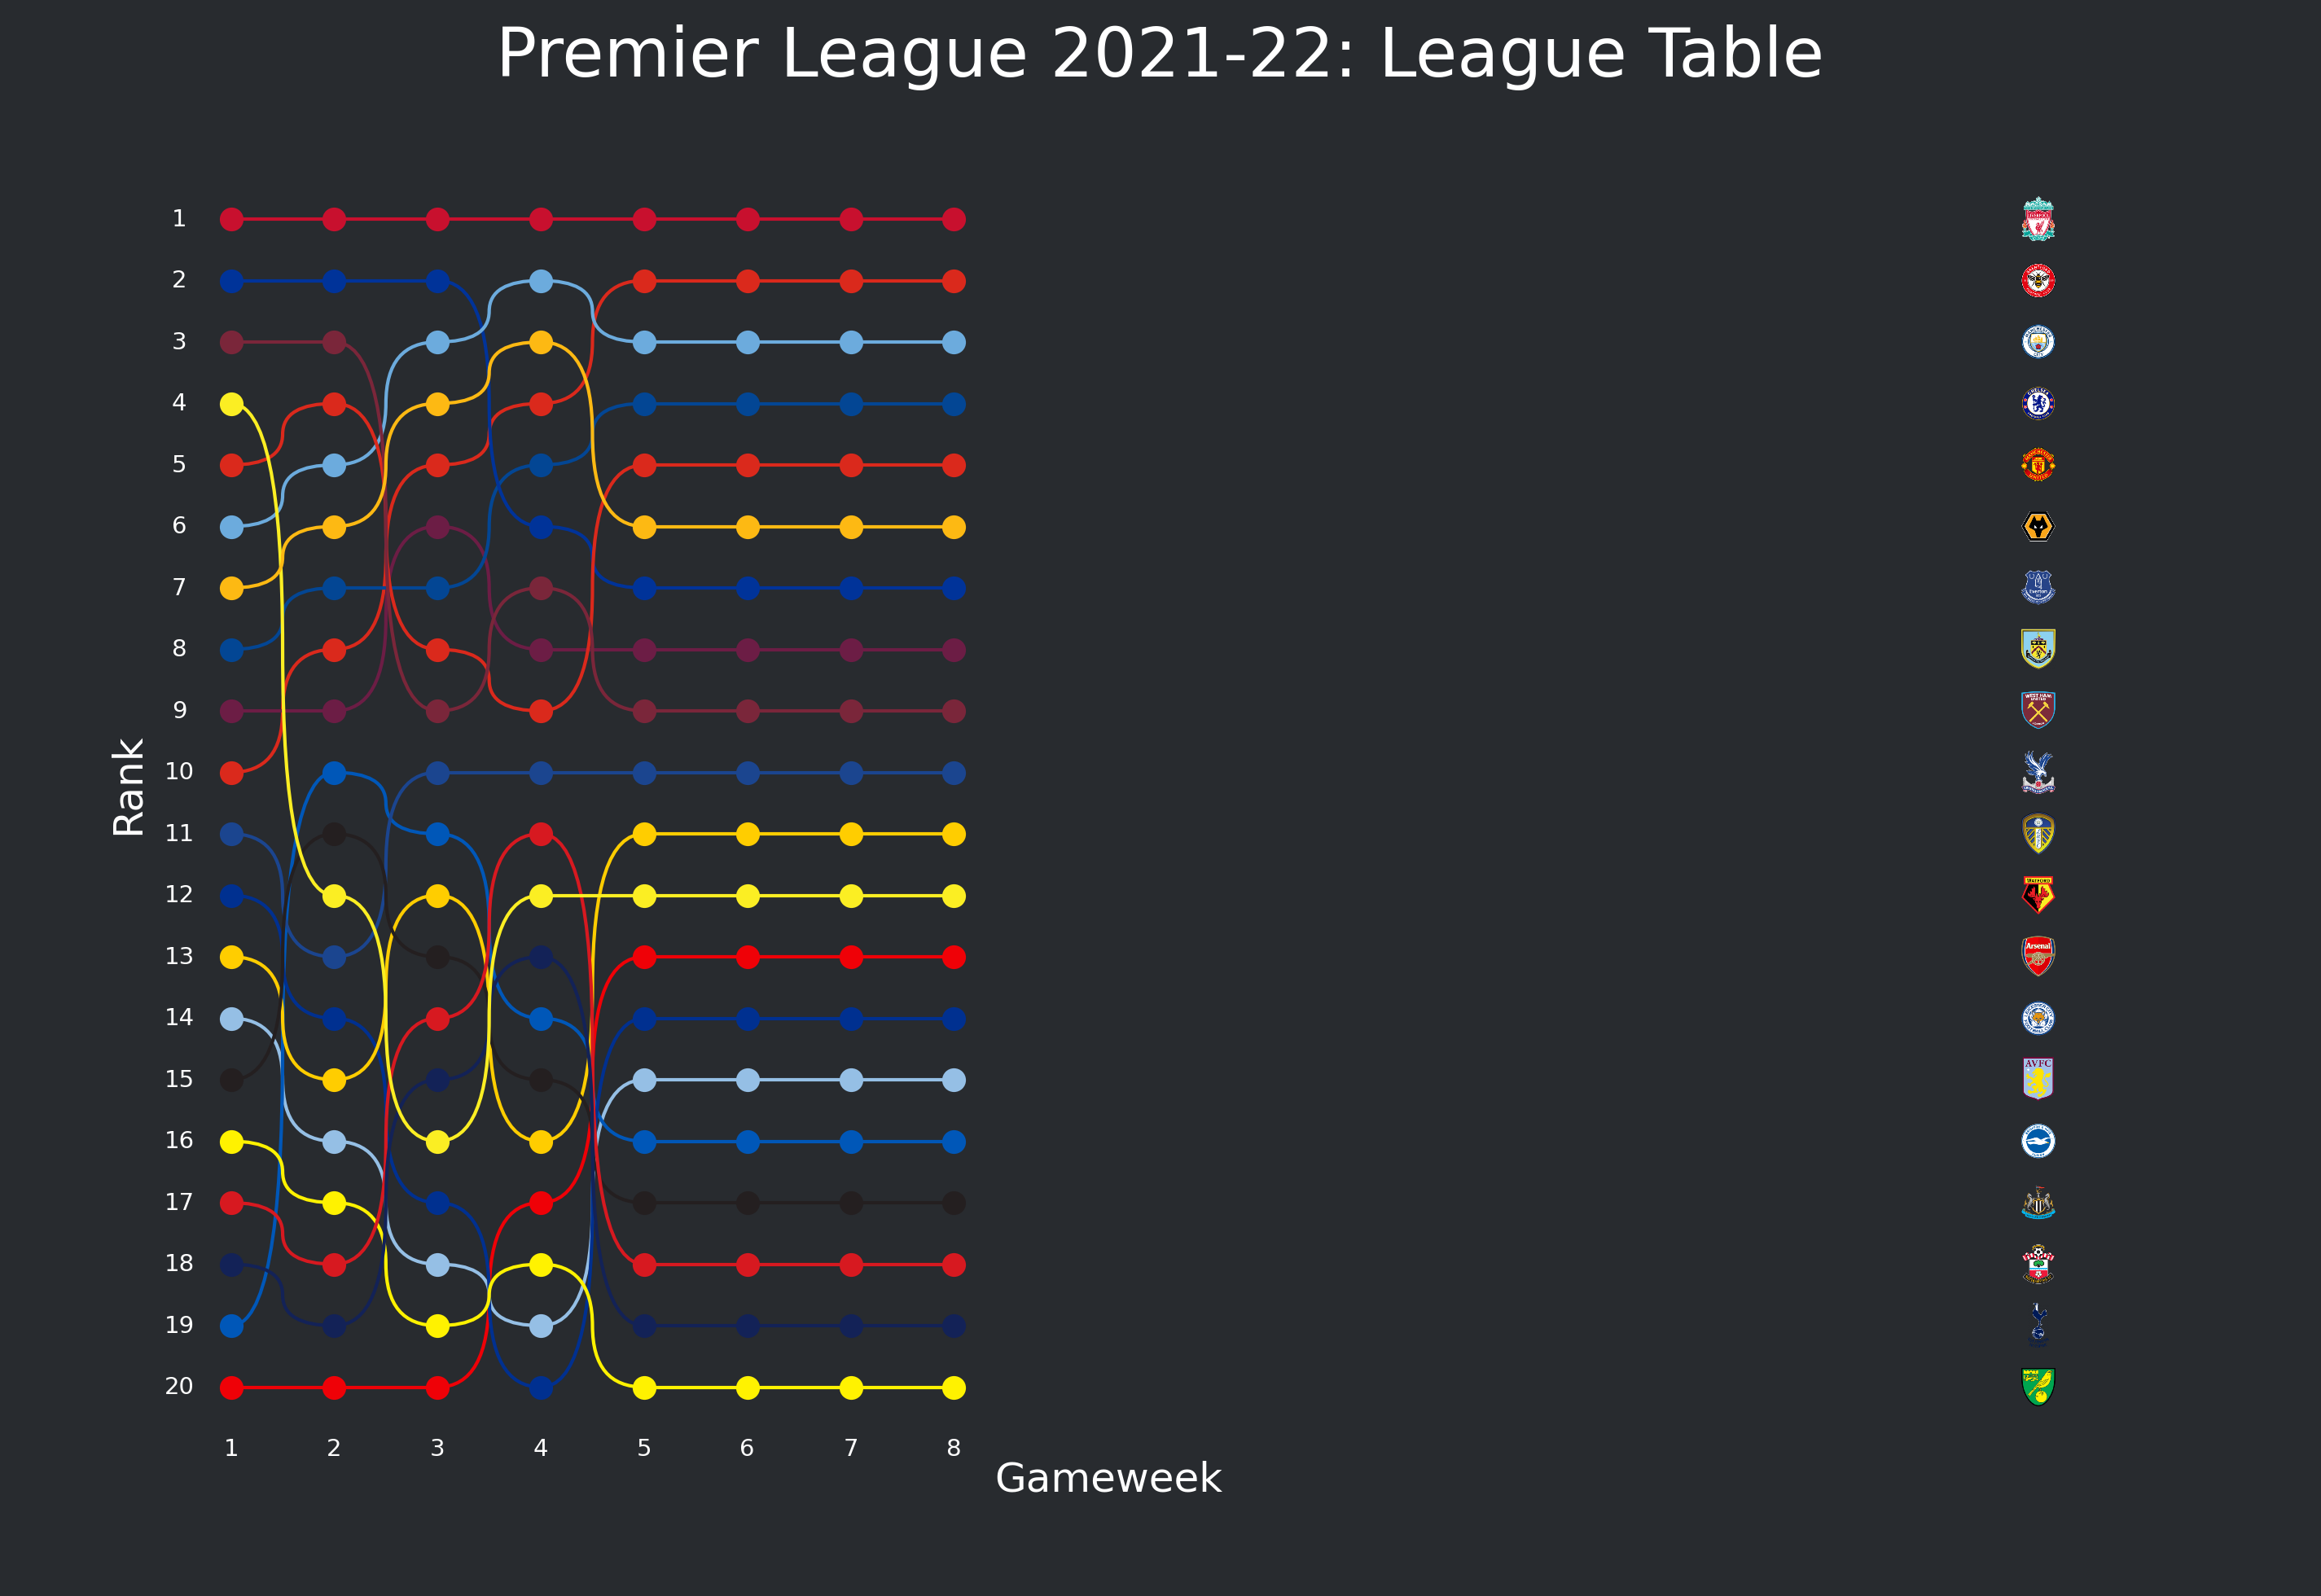

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for team_name, color, img_path in zip(colors.keys(), colors.values(), logos.values()):
    indices = xpts_season_table[xpts_season_table == team_name].stack().index.tolist()

    coords = [(int(idx[1]), idx[0]) for idx in indices]
    coords = sorted(coords, key=lambda x: x[0])

    # Plot the dot with the team's color
    for idx in indices:
        ax.scatter(int(idx[1]), idx[0], fc=color, zorder=1)

    # Plot the lines
    for p1, p2 in zip(coords[:-1], coords[1:]):
        patch = bezier_path(p1, p2, color)
        ax.add_patch(patch)

    # Plot the team logo
    imscatter(x=17.5, y=coords[-1][-1], image = img_path, ax=ax, zoom=0.1)

ax.set_axis_off()
ax.set(xlim=(-2,20), ylim=(-2,22))
ax.title.set(text='Premier League 2021-22: League Table', fontsize=20)

ax.text(8.5, 20.5, 'Gameweek', fontsize=12, va='center', ha='center')
ax.text(-1, 10, 'Rank', rotation=90, fontsize=12, va='bottom', ha='center')

[ax.text(i, 20, i+1, ha='center', va='center', size=7) for i in range(0, current_gw)]
[ax.text(-0.5, i, i+1, ha='center', va='center', size=7) for i in range(20)]

ax.invert_yaxis()

## Table

In [32]:
games = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
games = (games
    .loc[games['league_id'] == 2411]
    .loc[games['season'] == 2021]
    .dropna()
    )

In [33]:
league_table = league_table.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man Utd': 'Manchester United',
    'Norwich': 'Norwich City',
    'Spurs': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [34]:
league_table = (
    league_table
    .merge(games.groupby('team1').sum(), left_on='name', right_on='team1')
    .loc[:, ['name', 'short_name', 'Points', 'xPoints', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]
    .rename(columns={
        'xg1': 'xG',
        'xg2': 'xGA',
        'nsxg1': 'nsxG',
        'nsxg2': 'nsxGA' 
        })
    .merge(games.groupby('team2').sum(), left_on='name', right_on='team2')
    .loc[:, ['name', 'short_name', 'Points', 'xPoints', 'xG', 'xGA', 'nsxG', 'nsxGA', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]
)

league_table['xG'] = league_table['xG'] + league_table['xg2']
league_table['xGA'] = league_table['xGA'] + league_table['xg1']
league_table['nsxG'] = league_table['nsxG'] + league_table['nsxg2']
league_table['nsxGA'] = league_table['nsxGA'] + league_table['nsxg1']
league_table = league_table.loc[:, ['name', 'short_name', 'Points', 'xPoints', 'xG', 'xGA', 'nsxG', 'nsxGA']]

In [35]:
text_color = "w"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = 'black'

Text(0.8, 0.1, 'Created by Paul Fournier')

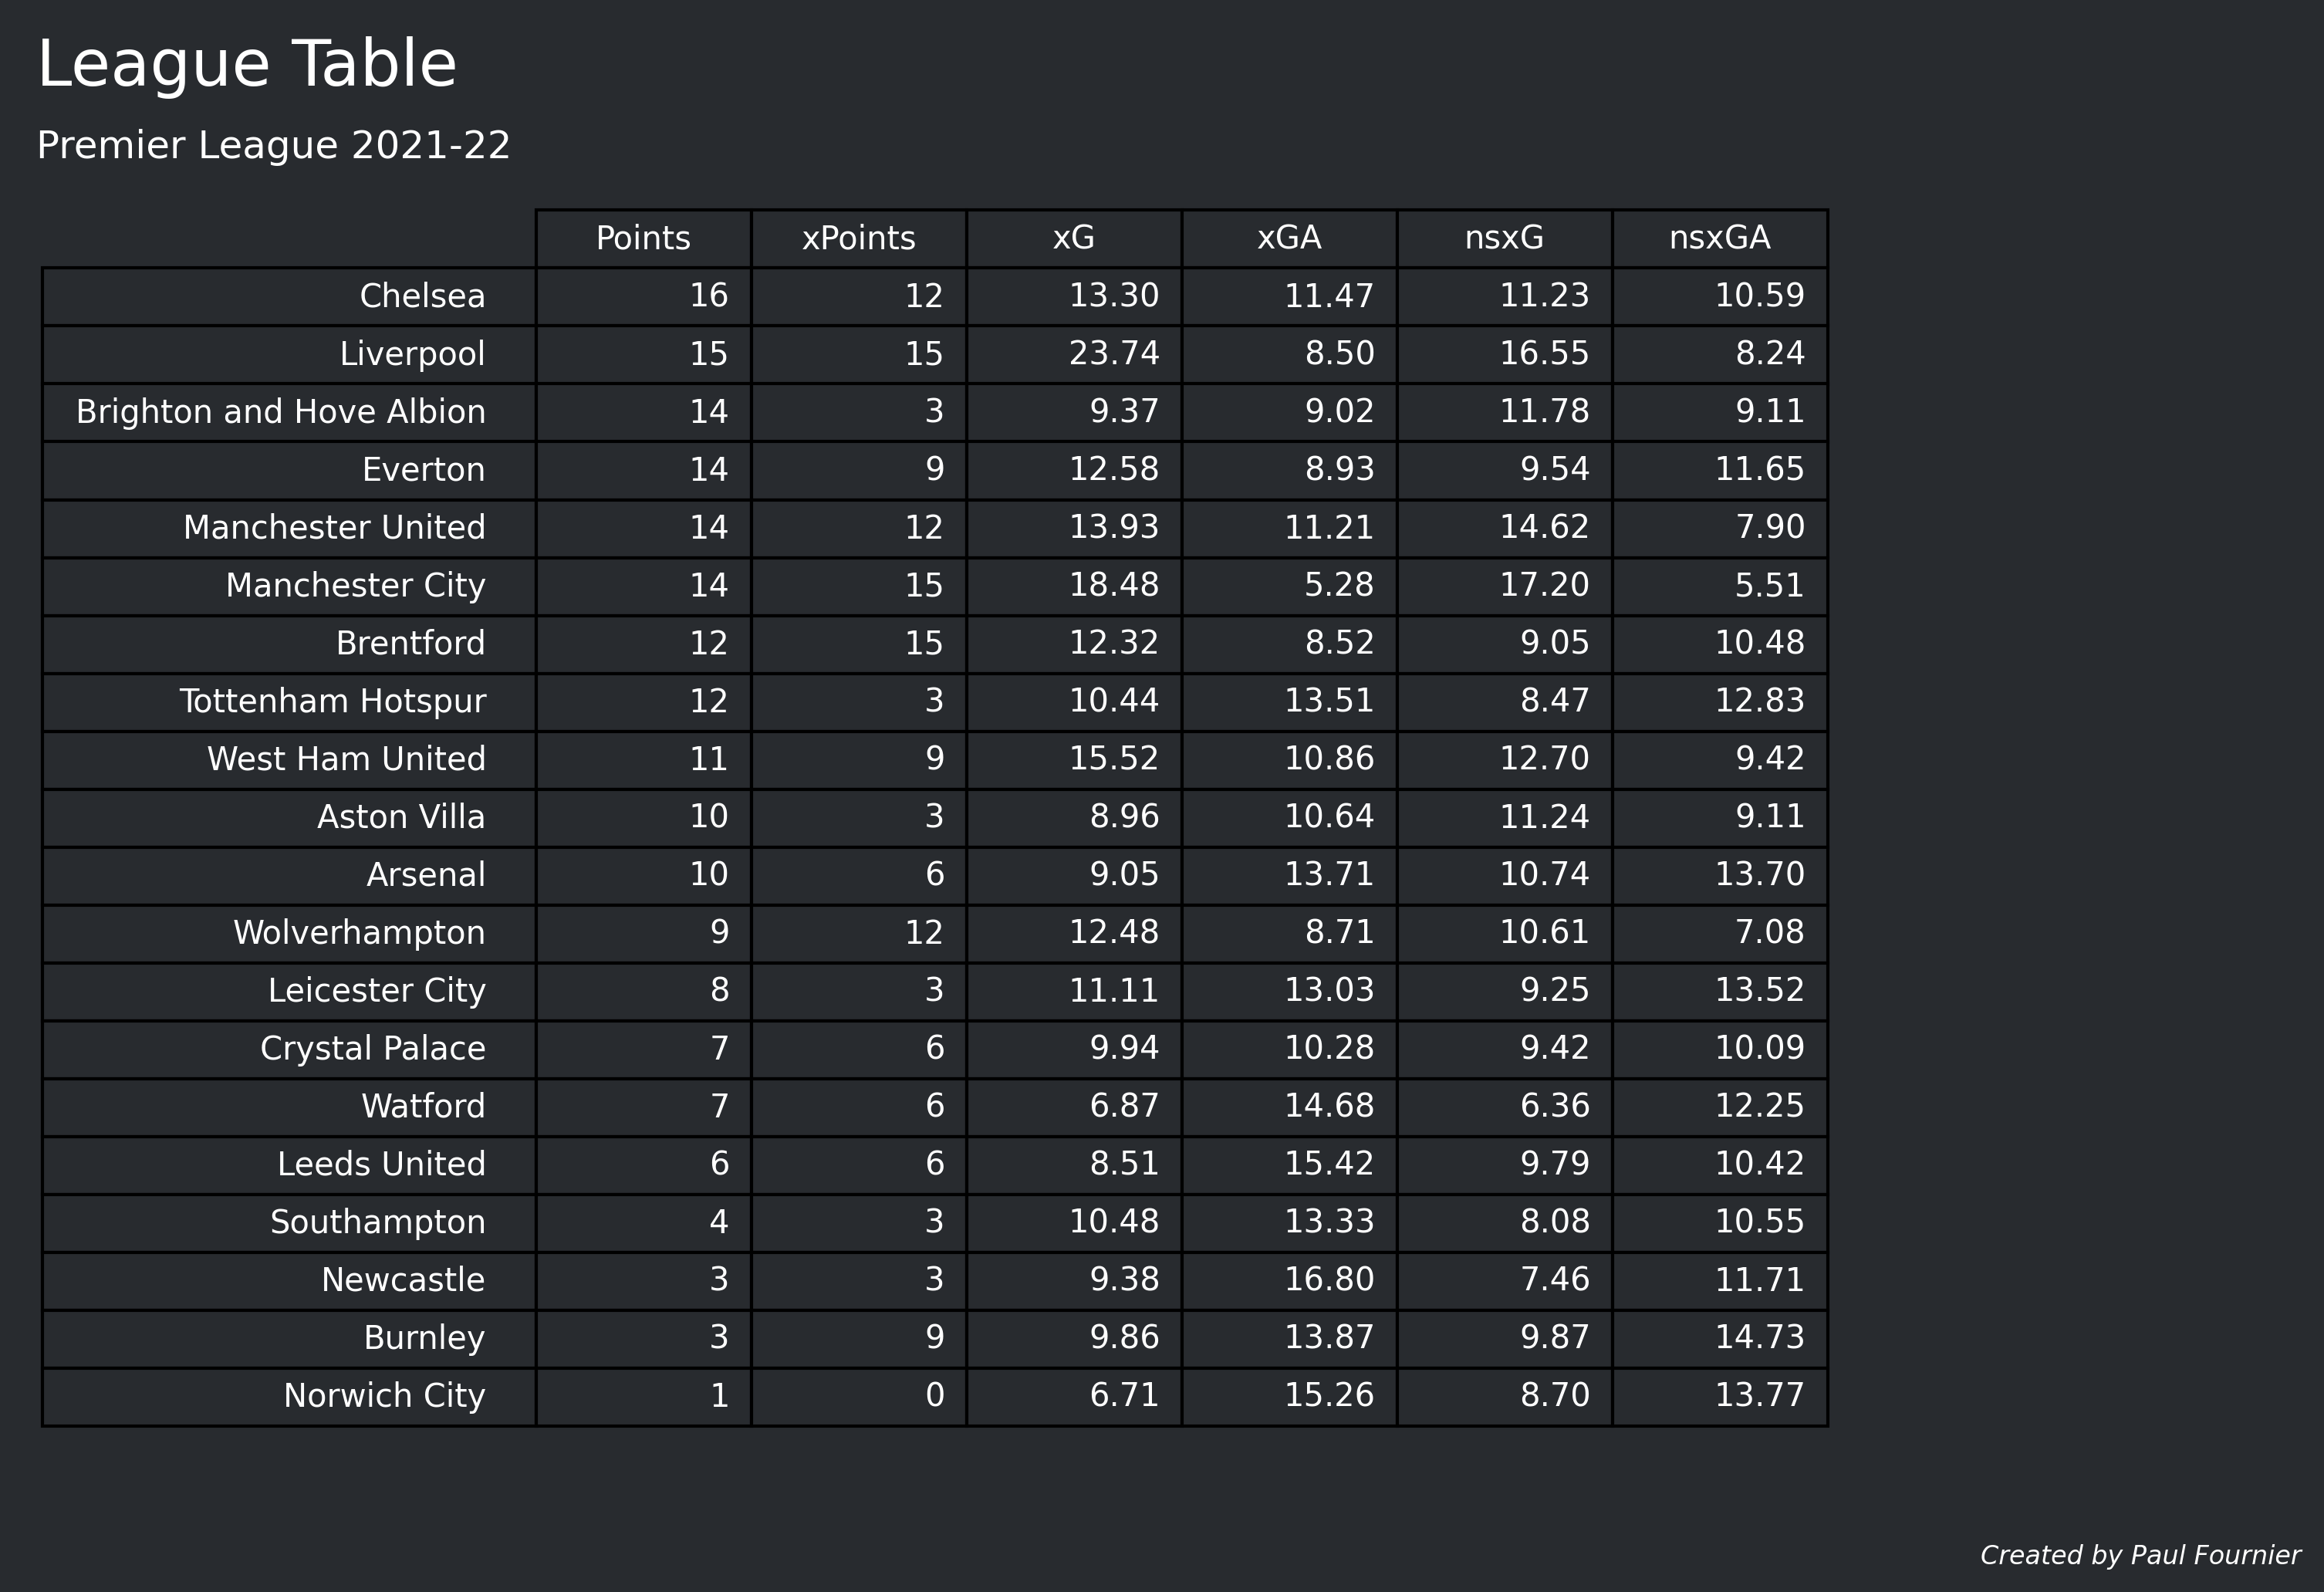

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

column_headers = ['Points', 'xPoints', 'xG', 'xGA', 'nsxG', 'nsxGA']
row_headers = league_table.sort_values('Points', ascending=False).name.values

background_rgb = [40/255, 43/255, 47/255, 1]
ccolors = np.repeat([background_rgb], len(column_headers), 0)
rcolors = np.repeat([background_rgb], len(row_headers), 0)

cell_text = []
for row in league_table.sort_values('Points', ascending=False).reset_index()[['Points', 'xPoints', 'xG', 'xGA', 'nsxG', 'nsxGA']].values:
    cell_text.append([f'{x:1.2f}' if i >= 2 else int(x) for i, x in enumerate(row)])

the_table = ax.table(
    cellText=cell_text,
    rowLabels=row_headers,
    rowColours=rcolors,
    rowLoc='right',
    colColours=ccolors,
    colLabels=column_headers,
    loc='center',
    colWidths=[.1]*6
    )
the_table.scale(1, 1.5)

for i in range(1, 21):
    for j in range(0, 6):
        the_table[(i, j)].set_facecolor(background)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

fig_text(
    x=0.1, y=0.925,
    s="League Table",
    fontweight="regular", fontsize=20, fontfamily=title_font,
    color=text_color, alpha=1)

fig_text(
    x=0.1, y=0.875,
    s="Premier League 2021-22",
    fontweight="regular", fontsize=12, fontfamily=title_font,
    color=text_color, alpha=1)

fig.text(
    0.8, 0.1, "Created by Paul Fournier",
    fontstyle="italic", fontsize=8, fontfamily=watermark_font, color=text_color)
